In [1]:
import numpy as np

from GRAPE import *
import matplotlib.pyplot as plt
from qiskit import Aer, execute

In [2]:
J = np.zeros((3, 3))
J[0][1] = 0.1385
J[1][2] = 0.01304
J[0][2] = 0.00148

CX = np.eye(4)
CX[2][2] = 0
CX[3][3] = 0
CX[2][3] = 1
CX[3][2] = 1

SWAP = np.eye(4)
SWAP[1][1] = 0
SWAP[2][2] = 0
SWAP[1][2] = 1
SWAP[2][1] = 1

TOFFOLI = np.eye(8)
TOFFOLI[6][6] = 0
TOFFOLI[7][7] = 0
TOFFOLI[6][7] = 1
TOFFOLI[7][6] = 1

C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution = evolution @ (math.cos(math.pi / 2 * self.J[i][j] * self.time) * np.eye(2 ** self.size,
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  dtype=complex) - 1j * math.sin(
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix = math.cos(self.params[0] / 2) * self.__Id - 1j * math.sin(self.params[0] / 2) * (
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  math.cos(self.params[1]) * self.__X + math.sin(self.params[1]) * self.__Y)


distance: 15.998136 ; time: -0.7


C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution = evolution @ (math.cos(math.pi / 2 * self.J[i][j] * self.time) * np.eye(2 ** self.size,
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  dtype=complex) - 1j * math.sin(


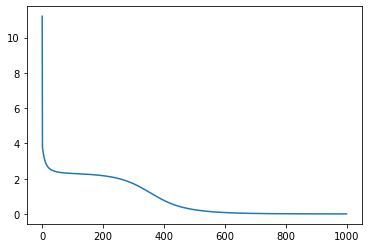

In [3]:
n = 1
m = 1000
k = 4

evolutions = [Evolution(CX, k) for _ in range(n)]

for evolution in evolutions:
    evolution.noise = 0.05
    evolution.randomize_params()
    evolution.set_j(J)

losses = [evolution.descend(steps=m, track_distance=True) for evolution in evolutions]

for loss in losses:
    plt.plot(np.real(loss))
for i in range(n):
    print("distance:", evolutions[i].distance.round(6).real, "; time:", evolutions[i].time.round(2))



In [4]:
circuit = evolutions[0].to_qiskit()

C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  circuit.hamiltonian(self.hamiltonian, float(self.time), circuit.qubits)
C:\Users\Panfe\anaconda3\envs\GRAPE\lib\site-packages\qiskit\circuit\quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


In [5]:
circuit.draw()

global phase: 5π/4
     ┌──────────────────┐┌──────────────┐┌───────────────────┐┌──────────────┐»
q_0: ┤ R(4.5857,1.7128) ├┤0             ├┤ R(0.12439,2.4937) ├┤0             ├»
     ├──────────────────┤│  Hamiltonian │└┬──────────────────┤│  Hamiltonian │»
q_1: ┤ R(1.2544,4.8127) ├┤1             ├─┤ R(2.0424,4.6365) ├┤1             ├»
     └──────────────────┘└──────────────┘ └──────────────────┘└──────────────┘»
«     ┌──────────────────┐┌──────────────┐┌──────────────────┐┌──────────────┐
«q_0: ┤ R(3.0753,3.9917) ├┤0             ├┤ R(1.5969,4.6944) ├┤0             ├
«     └┬────────────────┬┘│  Hamiltonian │├──────────────────┤│  Hamiltonian │
«q_1: ─┤ R(6.033,3.802) ├─┤1             ├┤ R(3.0587,5.4731) ├┤1             ├
«      └────────────────┘ └──────────────┘└──────────────────┘└──────────────┘

In [6]:
backend = Aer.get_backend('unitary_simulator')
job = execute(circuit, backend)
result = job.result()
matrix = result.get_unitary(circuit, decimals=2)
print(evolutions[0].matrix.round(1), "\n" ,matrix.round(0))

[[-1.-0.j  0.+0.j  0.-0.j -0.-0.j]
 [-0.+0.j -1.+0.j -0.-0.j -0.+0.j]
 [ 0.-0.j  0.+0.j  0.-0.j -1.-0.j]
 [ 0.-0.j  0.-0.j -1.+0.j -0.-0.j]] 
 [[-1.-0.j  0.+0.j  0.-0.j -0.-0.j]
 [-0.+0.j -1.+0.j -0.-0.j -0.+0.j]
 [ 0.-0.j  0.+0.j  0.-0.j -1.-0.j]
 [ 0.-0.j  0.-0.j -1.+0.j -0.-0.j]]


C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution = evolution @ (math.cos(math.pi / 2 * self.J[i][j] * self.time) * np.eye(2 ** self.size,
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  dtype=complex) - 1j * math.sin(


In [7]:
for i in range(n):
    print("distance:", evolutions[i].distance.round(6).real)
    for j in range(k):
        print(evolutions[i].gates[j].time.round(2).real, evolutions[i].gates[j].time.round(2).real % 28.88, end=" ")
    print("\n")


distance: 15.998136
0.28 0.28 1.24 1.24 -2.45 26.43 0.23 0.23 

